# Introduction

Do not spend too much time trying to get very tiny metrics improvement. Once you have a model with a correct predictive power, you should better spend time explaining your data cleaning & preparation pipeline as well as explanations & visualizations of the results.

The goal is to see your fit with our company culture & engineering needs, spending 50h on an over-complicated approach will not give you bonus points compared to a simple, yet effective, to-the-point solution.

## About the data

The dataset you will be working with is called Emo-DB and can be found [here](http://emodb.bilderbar.info/index-1280.html).

It is a database containing samples of emotional speech in German. It contains samples labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information")
   
The goal of this project is to develop a model which is able to **classify samples of emotional speech**. Feel free to use any available library you would need, but beware of re-using someone else's code without mentionning it!

## Deliverable

The end-goal is to deliver us a zip file containing:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a technical presentation covering the important aspects of your work
* A Dockerfile which defines a container for the project. The container should handle everything (download the data, run the code, etc...). When running the container it should expose the jupyter notebook on one port and expose a Flask API on another one. The Flask app contains two endpoints:
  - One for training the model
  - One for querying the last trained model with an audio file of our choice in the dataset
* A README.md which should contain the commands to build and run the docker container, as well as how to perform the queries to the API. 
* Any necessary .py, .sh or other files needed to run your code.

___
# Approach for the exercise

Dear Visium team, thank you first and foremost for selecting me for this exercise. I will in the following lines explain the vision that guided me throughout the realisation of this project. 

First and foremost, this project is an end-to-end project which contains both the data loading, training and deployment. The time frame should have been of approximately 10 hours. 

Given that I never touched flask nor speech files during my career, I did not expect to engineer something that provided state-of-the-art results by myself in the given timeframe. My main focus was then to find the necessary ressources available on many open source projects, to understand their approach and to adapt it for our project and, most importantly, to make it deployable.

I will by no mean try to hide the fact that some pieces of code were greatly inspired from other projects. I will spare you the trouble by presenting the main codes that helped me:

- https://github.com/IliaZenkov/transformer-cnn-emotion-recognition/
- https://github.com/Data-Science-kosta/Speech-Emotion-Classification-with-PyTorch
- https://github.com/Krlier/SimpleProject

My goal being to provide a great analysis of this problem and to explain why the technique that I assembled from other's intelectual and my own is suited for this project. Without further ado, lets dig into this project.


___

# Libraries Loading

In [1]:
from IPython.display import Audio
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import copy
from collections import defaultdict

import torch
import torch.nn as nn

from einops import rearrange

from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

%matplotlib inline

# Data Preparation & Cleaning

From the dataset homepage, we define a list of dictionnaries to be able to process the dataset formatting.

In [2]:
# Set the seed to obtain the same results
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

#? just a simple function to know if the messages will be in 
# german or english
deutsch_sprechen = False
language = 0 if deutsch_sprechen else 1

speaker_code = {
    "03" : "male, 31 years old",
    "08" : "female, 34 years",
    "09" : "female, 21 years",
    "10" : "male, 32 years",
    "11" : "male, 26 years",
    "12" : "male, 30 years",
    "13" : "female, 32 years",
    "14" : "female, 35 years",
    "15" : "male, 25 years",
    "16" : "female, 31 years"
}

sentence_code = {
    "a01" : ("Der Lappen liegt auf dem Eisschrank.", "The tablecloth is lying on the frigde.")[language],
    "a02" : ("Das will sie am Mittwoch abgeben.", "She will hand it in on Wednesday.")[language],
    "a04" : ("Heute abend könnte ich es ihm sagen.", "Tonight I could tell him.")[language],
    "a05" : ("Das schwarze Stück Papier befindet sich da oben neben dem Holzstück.", "The black sheet of paper is located up there besides the piece of timber.")[language],
    "a07" : ("In sieben Stunden wird es soweit sein.", "In seven hours it will be.")[language],
    "b01" : ("Was sind denn das für Tüten, die da unter dem Tisch stehen?", "What about the bags standing there under the table?"[language])[language],
    "b02" : ("Sie haben es gerade hochgetragen und jetzt gehen sie wieder runter.", "They just carried it upstairs and now they are going down again.")[language],
    "b03" : ("An den Wochenenden bin ich jetzt immer nach Hause gefahren und habe Agnes besucht.", "Currently at the weekends I always went home and saw Agnes.")[language],
    "b09" : ("Ich will das eben wegbringen und dann mit Karl was trinken gehen.", "I will just discard this and then go for a drink with Karl.")[language],
    "b10" : ("Die wird auf dem Platz sein, wo wir sie immer hinlegen.", "It will be in the place where we always store it.")[language]
}

emotion_code = {
    "W" : ("Ärger (Wut)", "Anger")[language],
    "L" : ("Langeweile", "boredom")[language],
    "E" : ("Ekel", "disgust")[language],
    "A" : ("Angst", "anxiety/fear")[language],
    "F" : ("Freude", "happiness")[language],
    "T" : ("Trauer", "sadness")[language],
    "N" : ("Neutral", "Neutral")[language]
}

emotion_id = {
    "W" : 0,
    "L" : 1,
    "E" : 2,
    "A" : 3,
    "F" : 4,
    "T" : 5,
    "N" : 6
}

id_emotion = {
    0 : "W",
    1 : "L",
    2 : "E",
    3 : "A",
    4 : "F",
    5 : "T",
    6 : "N"
}

def get_emotion(file_path):
    # Get the letter for the emotion and convert it 
    # into his unique number
    
    file_name = file.split("/")[-1].split(".")[0]
    return emotion_id.get(file_name[5])

def get_speaker(file_path):
    # Get the letter for the emotion and convert it 
    # into his unique number
    
    file_name = file.split("/")[-1].split(".")[0]
    return file_name[:2]

def file_info(file_path, german = False):
    
    file_name = file_path.split("/")[-1].split(".")[0]
    
    speaker = speaker_code.get(file_name[:2], "unknown")
    sentence = sentence_code.get(file_name[2:5], ("text nicht erkannt","text not recognized"))
    emotion = emotion_code.get(file_name[5], ("emotion nicht erkannt","emotion not recognized"))
    print(f"The file {file_name}.wav is spoken by a {speaker}. \nThe sentence is: {sentence}.  \nThe emotion played is: {emotion}")
    
    

Define the path to our data. In the case of the Emo-DB dataset, the name of each wav file contains all the information that we need, being the emotion, the kind of sentence, and the type of individual speaking it.

In [3]:
data_path = "../data"
wav_path = os.path.join(data_path, "wav")

Let's have a taste of this dataset and see how an audio sample looks (and sounds).

In [4]:
index = 0
#? we try a sampling rate of 48000 at first. This might be too much but can will adjust it later on.
SAMPLING_RATE = 48000

test_file = os.path.join(wav_path, os.listdir(wav_path)[index])
Audio(test_file)

In [5]:
test_audio, _ = librosa.load(test_file, sr = SAMPLING_RATE)

Text(0.5, 1.0, 'Sound profile in amplitude')

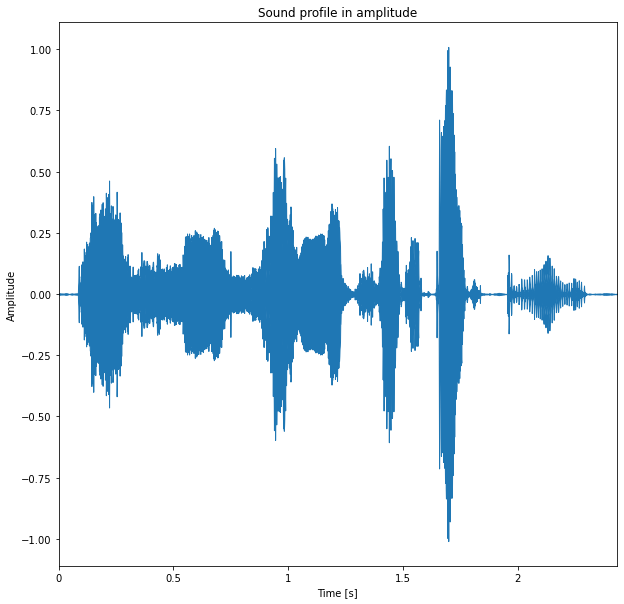

In [6]:
fig, ax = plt.subplots(figsize = (10,10))
plot = librosa.display.waveplot(test_audio, sr = SAMPLING_RATE, ax = ax)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.set_title("Sound profile in amplitude")

This way of processing the audio file gives us mainly the key-part of the sentence amplitude wise. This might be enough in the case where we want to identificate which sentence is which. Nonetheless, hthis might not be too useful in our case. Given that we want to extract the emotion out of the speech files, we might want to take a look into the frequency-wise behavior of each files. 

In [7]:
D = librosa.stft(test_audio)  # Apply a Fast fourier transform on the signal
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max) # Convert the amplitude to DB

By using some simple tools such as the fourier transform, we are able to get an overview of the frequency analysis of each speech file. This gives us a much better data density to process our data than just using a simple amplitude.

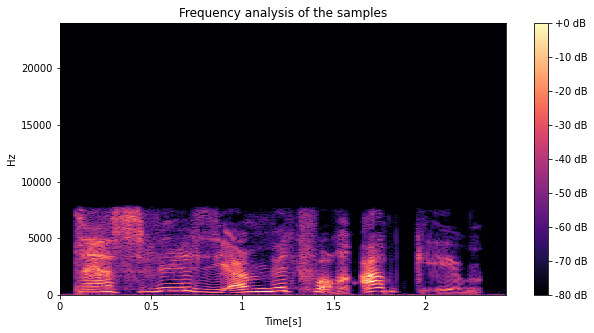

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db, sr = SAMPLING_RATE, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Frequency analysis of the samples', xlabel="Time[s]")

fig.colorbar(img, ax=ax, format="%+2.f dB")

One this graph, we can see that the audio has a span going to 8000Hz at the maximum. Our frequency of sampling hence needs to be twice the maximum visible frequency (We take as hypothesis that the whole dataset was sampled at the same frequency). Hence :

In [9]:
SAMPLING_RATE = 16000

Lets now take a quick look at the initial distribution of emotions from our dataset. The most interesting parts are the distributions of the sentences, the distribution of the genders, speakers and, of course, the distribution of the emotions in our dataset. Given that the age of the speakers is between 25 and 34, we will assume that the tone of voice is staying the same over this span of time.

In [10]:
counter_emotions = {}
counter_gender = {}
counter_sentence = {}
counter_speaker = {}

lengths = []

for file in os.listdir(wav_path):
    text = file.split("/")[-1].split(".")[0]
    
    gender = speaker_code[text[:2]][0]
    gender = "male" if speaker_code[text[:2]][0] == "m" else "female"
    
    #Get the emotion
    counter_gender[gender] = counter_gender.get(gender, 0) + 1
    
    #Get the gender
    counter_emotions[text[5]] = counter_emotions.get(text[5], 0) + 1
    
    #Get the sentences
    counter_sentence[text[2:5]] = counter_sentence.get(text[2:5], 0) + 1
                    
    #Get the speakers
    counter_speaker[text[:2]] = counter_speaker.get(text[:2], 0) + 1
    
    
    # Get the duration of each files
    file_path = os.path.join(wav_path, file)
    audio, sample_rate = librosa.load(file_path, sr = SAMPLING_RATE)
    lengths.append(librosa.get_duration(audio, sample_rate))
                     
#? reorder counter emotions for later on task
counter_emotions = {key: counter_emotions[key] for (key, value) in emotion_id.items()}

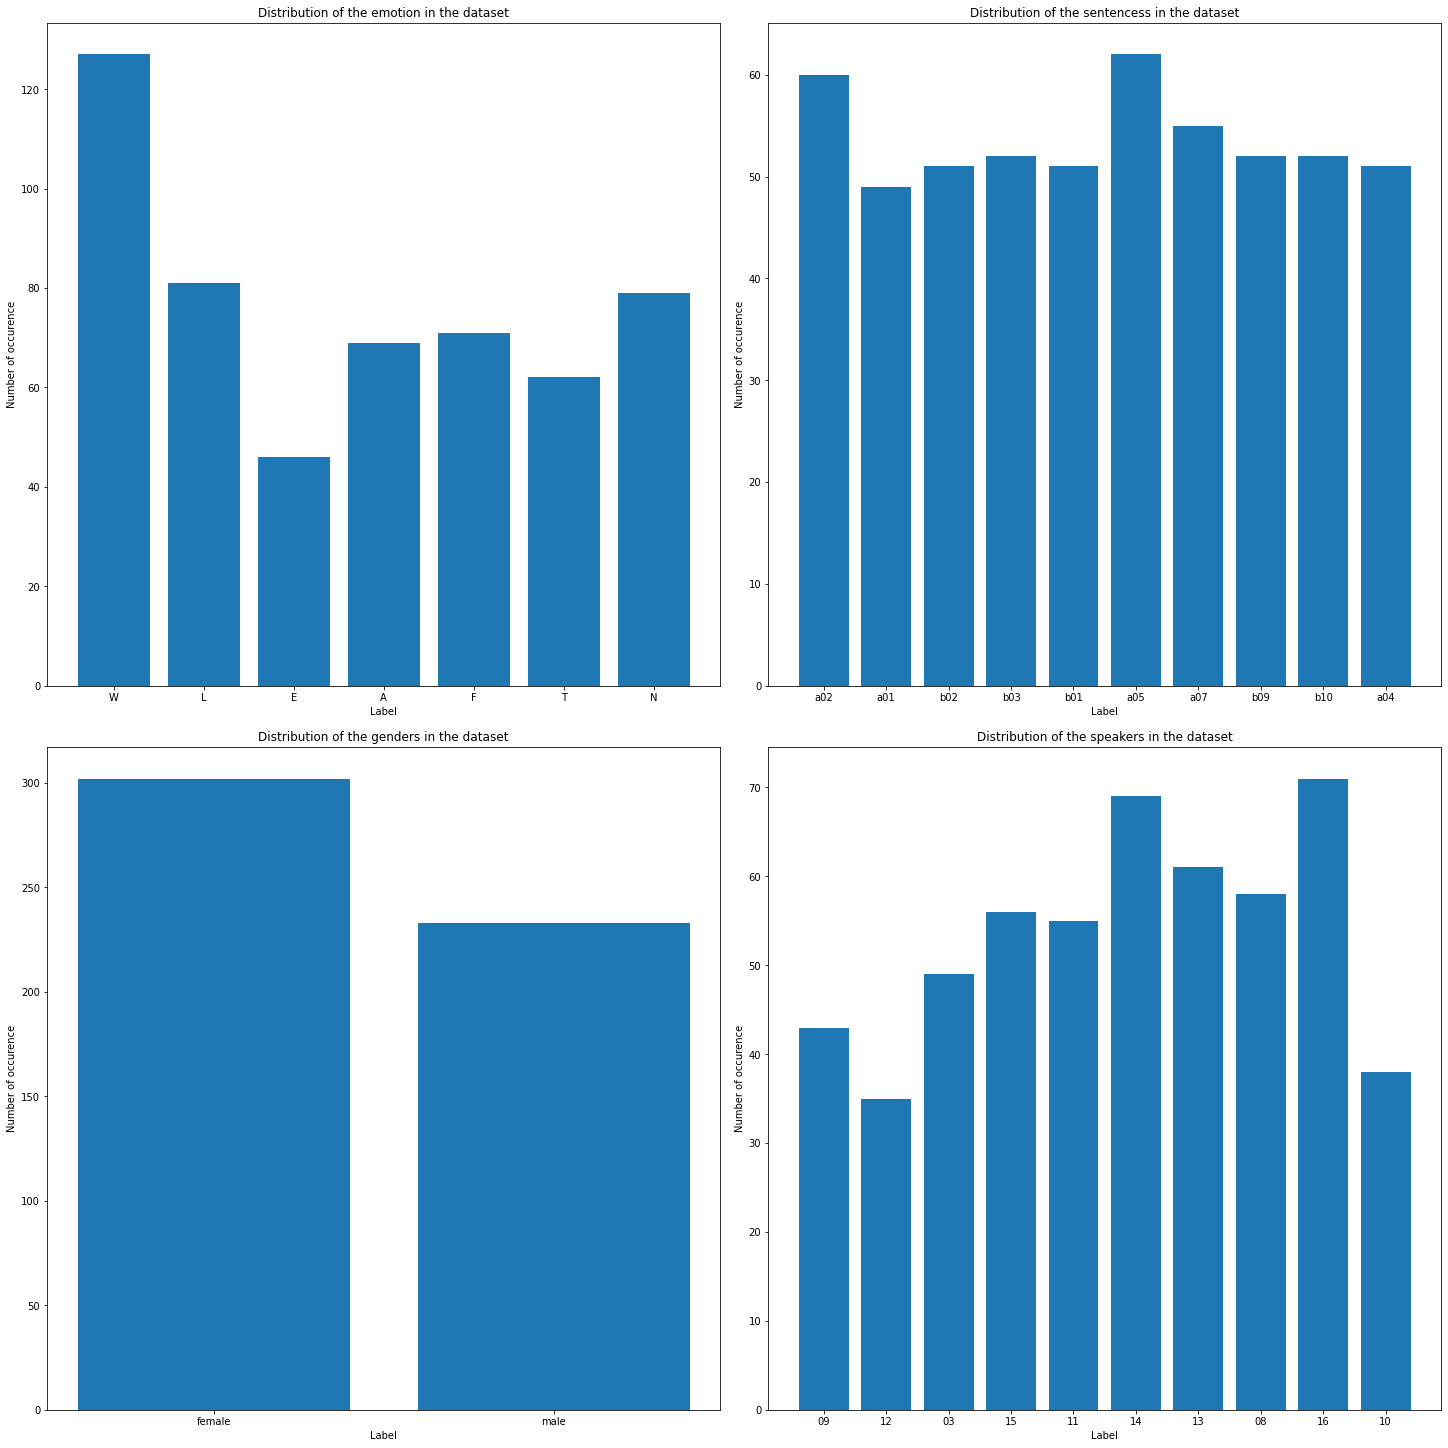

The most represented emotion here is: Anger
The most represented gender here is: ('female', 302)
The most represented speaker here is: female, 31 years
The most represented sentence here is:
 It will be in the place where we always store it.

Total number of occurences: 535


In [11]:

fig, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize = (20,20))

ax = axes[0,0]

# Emotion distribution

ax.bar(range(len(counter_emotions)), list(counter_emotions.values()), align='center')
ax.set_xticks(range(len(counter_emotions)))
ax.set_xticklabels( list(counter_emotions.keys()))
ax.set_ylabel("Number of occurence")
ax.set_xlabel("Label")
ax.set_title("Distribution of the emotion in the dataset")

ax = axes[1,0]

# Gender distribution

ax.bar(range(len(counter_gender)), list(counter_gender.values()), align='center')
ax.set_xticks(range(len(counter_gender)))
ax.set_xticklabels( list(counter_gender.keys()))
ax.set_ylabel("Number of occurence")
ax.set_xlabel("Label")
ax.set_title("Distribution of the genders in the dataset")

ax = axes[0,1]

# Gender distribution

ax.bar(range(len(counter_sentence)), list(counter_sentence.values()), align='center')
ax.set_xticks(range(len(counter_sentence)))
ax.set_xticklabels( list(counter_sentence.keys()))
ax.set_ylabel("Number of occurence")
ax.set_xlabel("Label")
ax.set_title("Distribution of the sentencess in the dataset")

ax = axes[1,1]

# Gender distribution
ax.bar(range(len(counter_speaker)), list(counter_speaker.values()), align='center')
ax.set_xticks(range(len(counter_speaker)))
ax.set_xticklabels( list(counter_speaker.keys()))
ax.set_ylabel("Number of occurence")
ax.set_xlabel("Label")
ax.set_title("Distribution of the speakers in the dataset")


plt.show()

print(f"The most represented emotion here is: {emotion_code.get(max(counter_emotions))}")
print(f"The most represented gender here is: {max(counter_gender.items(), key=lambda x: x[1])}")
print(f"The most represented speaker here is: {speaker_code.get(max(counter_speaker))}")
print(f"The most represented sentence here is:\n {sentence_code.get(max(counter_sentence))}\n")

print(f"Total number of occurences: {sum(counter_emotions.values())}")

It seems that we have a dataset of fairly angry people. Overal, the sentence are evenly distributed in our dataset and the slight imbalance between male and female in our dataset should not cause us much trouble in our task. 

We can realise that we have in total 535 wav files which might be too little. Data augmentations such as adding white noise would be a great way to expand our data.

Finally, to prevent the imbalance between the validation and training set, we needs to ensure that the distibution of our main feature, the emotions, remain the same in both of them

Text(0.5, 1.0, 'distribution of the length for the speech files')

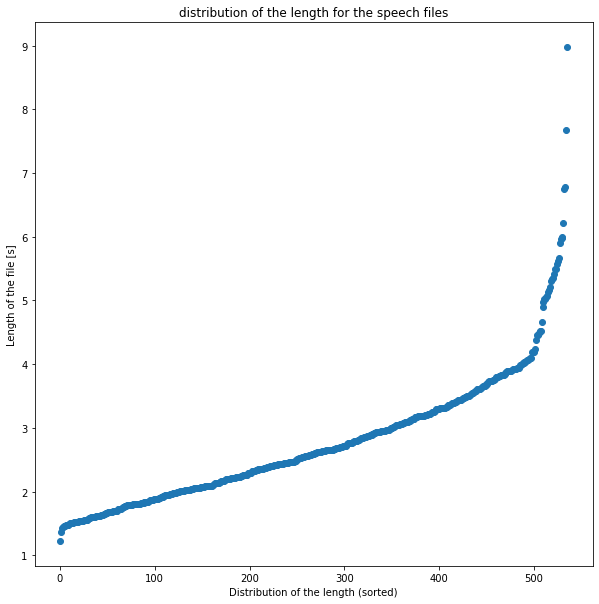

In [12]:
plt.figure(figsize = (10,10))
plt.scatter(np.linspace(0,len(lengths),len(lengths)), np.sort(lengths))
plt.ylabel("Length of the file [s]")
plt.xlabel("Distribution of the length (sorted)")

plt.title("distribution of the length for the speech files")

With the current distribution of the speech length, we can see a significant disparities between some files. There also seems to be some extreme cases going past 7 minutes. Lets take a look at those files before going further.

In [13]:

lengths_anormal = []

for file in os.listdir(wav_path):
    file_path = os.path.join(wav_path, file)
    audio, sample_rate = librosa.load(file_path, sr = SAMPLING_RATE)
    
    if librosa.get_duration(audio, SAMPLING_RATE) > 7:
        lengths_anormal.append(file_path)  
        
print(lengths_anormal)

['../data/wav/08b03Tc.wav', '../data/wav/08b02Tc.wav']


In [14]:
Audio(lengths_anormal[0])

In [15]:
Audio(lengths_anormal[1])

The samples are relevant during their whole duration, hence should not be considered as outliers. Our model should be able to be as length independant as it can be to take into account this wide spread of speech times.

__

## Data embedding 

Inspired by https://github.com/Data-Science-kosta/Speech-Emotion-Classification-with-PyTorch/blob/master/notebooks/stacked_cnn_lstm.ipynb

We load the data and create a list of IDs for each emotions. This way, during the sampling, there will be no imbalance between the val and train sets for each emotions.

We also add a padding for each file to be of the same perceived length. In our case, we use a zero padding.

In [16]:
max_length = 0

for id, file in enumerate(os.listdir(wav_path)):
    file_path = os.path.join(wav_path, file)
    # Load the data
    audio, sample_rate = librosa.load(file_path, sr = SAMPLING_RATE)
    
    max_length = max(max_length, len(audio))
    
print(f"The maximum length of the files is {max_length}")

The maximum length of the files is 143652


In [17]:
# We take a slightly longer file length so as our system understands that all instances are padded at the end.
PADDING = 150000

In [18]:
signals = []
emotion_ids = defaultdict(list)
speaker_ids = defaultdict(list)

for id, file in enumerate(os.listdir(wav_path)):
    file_path = os.path.join(wav_path, file)
    # Load the data
    audio, sample_rate = librosa.load(file_path, sr = SAMPLING_RATE)
    signal = np.zeros((PADDING))
    # Zero padding of the signals
    signal[:len(audio)] = audio
    signals.append(signal) 
    
    #? get the emotion of the file 
    # and put the id of the file in its list
    speaker_ids[get_speaker(file_path)].append([id, get_emotion(file_path)])

signals = np.stack(signals,axis=0)

Creation of our original train and val set. Currently, the formatting of the data is not that good since a frequency spectrum would be more suited for our data analysis. For now on however, we are just splitting the data and we will go through this step later on.

In [19]:
train_ids,val_ids = [],[]
#? the tag _pre defines the data before it being processed
X_train_pre,X_val_pre = [],[]
Y_train,Y_val = [],[]

# Define the training and validation ratio:
ratio = 0.75

stop = int(len(speaker_ids)*ratio)

train_keys = list(speaker_ids.keys())[:stop]
val_keys = list(speaker_ids.keys())[stop:]

for train_key in train_keys:
    
    id_train, emotions = np.array(speaker_ids[train_key]).T.tolist()
    train_ids.append(id_train)
    X_train_pre.append(signals[id_train])
    Y_train.append(emotions)
    
for val_key in val_keys:
    
    id_val, emotions = np.array(speaker_ids[val_key]).T.tolist()
    val_ids.append(id_val)
    X_val_pre.append(signals[id_val])
    Y_val.append(emotions)
    
X_train_pre = np.concatenate(X_train_pre,0)
X_val_pre = np.concatenate(X_val_pre,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
train_ids = np.concatenate(train_ids,0)
val_ids = np.concatenate(val_ids,0)

print(f'X_train_pre:{X_train_pre.shape}, Y_train:{Y_train.shape}')
print(f'X_val_pre:{X_val_pre.shape}, Y_val:{Y_val.shape}')

# check if all are unique
unique, count = np.unique(np.concatenate([train_ids,val_ids],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), signals.shape[0]))

X_train_pre:(368, 150000), Y_train:(368,)
X_val_pre:(167, 150000), Y_val:(167,)
Number of unique indexes is 535, out of 535


## REMOVE FOR NOW ON

Add some white gaussian noise to our signal for data augmentation purpose. This method for the processing is the one from : https://github.com/Data-Science-kosta/Speech-Emotion-Classification-with-PyTorch

In [20]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    # Generate noisy signal
    return signal + K.T * noise

In [21]:
aug_signals = []
aug_labels = []
for i in range(X_train_pre.shape[0]):
    signal = X_train_pre[i,:]
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        aug_labels.append(Y_train[i])
        aug_signals.append(augmented_signals[j,:])
    print("\r Processed {}/{} files".format(i,X_train_pre.shape[0]),end='')
aug_signals = np.stack(aug_signals,axis=0)
X_train_pre = np.concatenate([X_train_pre,aug_signals],axis=0)
aug_labels = np.stack(aug_labels,axis=0)
Y_train = np.concatenate([Y_train,aug_labels])
print('')
print(f'X_train_pre:{X_train_pre.shape}, Y_train:{Y_train.shape}')

 Processed 367/368 files
X_train_pre:(1104, 150000), Y_train:(1104,)


## Fast Fourier Transform spectrogram 

Get the fast fourier transform spectrograph for our speech samples. With the parameters of our moving window, we discretize our current sample of 15000 timesteps into a set of 586 timesteps. 

Concerning the resolution for the frequency, we choose to discretize the frequency range into 128values.

def getFFT(audio, sample_rate):
    fft = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                        )

    fft_db = librosa.power_to_db(fft, ref=np.max)
    return fft_db

# test function
audio, _ = librosa.load(test_file ,sr=SAMPLING_RATE)
signal = np.zeros((PADDING))
signal[:len(audio)] = audio

fig, ax = plt.subplots(figsize=(10,5))
fft_db = getFFT(signal, SAMPLING_RATE)
img = librosa.display.specshow(fft_db, sr=SAMPLING_RATE,y_axis='mel', x_axis='time')
fig.colorbar(img, ax=ax, format="%+2.f dB")

ax.set(title='Frequency analysis in intensity [db] of the samples', xlabel="Time [arbitrary unit]")
print('Fast fourier transform shape: ',fft_db.shape)

As an be seen, the fact that we are padding our values creates a lot of "blank" spaces in our spectrogram. In the next step, we will divide our spectrogram into chunks to be able to treat each pieces of audio independently. This technique will theoretically allow us to weight each chunks independently and to ignore those blanck spaces by adjusting the weight of their contributions.

fft_train = []
fft_val = []

print("Calculatin fft spectrograms for train set")
for i in range(X_train_pre.shape[0]):
    fft = getFFT(X_train_pre[i,:], sample_rate=SAMPLING_RATE)
    fft_train.append(fft)
    print("\r Processed {}/{} files".format(i,X_train_pre.shape[0]),end='')


print("\nCalculation fft spectrograms for val set")
for i in range(X_val_pre.shape[0]):
    fft = getFFT(X_val_pre[i,:], sample_rate=SAMPLING_RATE)
    fft_val.append(fft)
    print("\r Processed {}/{} files".format(i,X_val_pre.shape[0]),end='')

#del X_val_pre
#del X_train_pre

## Split into chunks

We split the original window in a set of chunks along its temporal axis. This will allow us to process each chunks individually to extract relevant features and then use the results to make our prediction

def splitIntoChunks(mel_spec,stride):
    t = mel_spec.shape[1]
    win_size = mel_spec.shape[0]
    
    num_of_chunks = int(t/stride)
    chunks = []
    for i in range(num_of_chunks):
        chunk = mel_spec[:,i*stride:i*stride+win_size]
        if chunk.shape[1] == win_size:
            chunks.append(chunk)
    return np.stack(chunks,axis=0)

# get chunks
# train set
fft_train_chunked = []
for fft_spec in fft_train:
    chunks = splitIntoChunks(fft_spec, stride=42)
    fft_train_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))
# val set
fft_val_chunked = []
for fft_spec in fft_val:
    chunks = splitIntoChunks(fft_spec, stride=42)
    fft_val_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))

print("Previous shape of the input: ",fft_spec.shape)
print("New shape for the input: ",chunks.shape)

### Final input

X_train = np.stack(fft_train_chunked,axis=0)
X_train = np.expand_dims(X_train,2)
print('Shape of X_train: ',X_train.shape)
X_val = np.stack(fft_val_chunked,axis=0)
X_val = np.expand_dims(X_val,2)
print('Shape of X_val: ',X_val.shape)

del fft_train_chunked
del fft_train
del fft_val_chunked
del fft_val

# Feature Engineering & Modeling

For the model creation, we divide our network in two steps. The first one consist in a series of convolutionnal filters with maxpool windows. This will allow it to extract the features of each 128*128 chunks of frequency spectrum. This gives us a 128 long array.

Then, with the regressed 128 features, we apply a simple LSTM on the regressed chunks of information. Our objective being to draw some relationships between each chunks. 

On an higher level, we can say that the Convolution filters are there to extract the emotions components of each chunks while the LSTM part tries to draw some relationships between each detected "emotions" before giving its final prediction. 

The end results of each LSTM block is then processed through an attention linear layer to get whihc part of the sentence yields the most weight.

The prediction takes the form of a simple fully connected layer with a softmax corresponding to each predicted emotions.

## Create Model

In [22]:
class HybridModel(nn.Module):
    def __init__(self,num_emotions, num_chunks=8):
        super().__init__()
        
        
        #Set of convolution filters to extract the relevant informations from each chunk
        self.convBlock = nn.Sequential(
            # 1. conv block
            nn.Conv2d(in_channels=1,
                                   out_channels=16,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.4),
        
        
            # 2. conv block
            nn.Conv2d(in_channels=16,
                                   out_channels=32,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.4),

            # 3. conv block
            nn.Conv2d(in_channels=32,
                                   out_channels=64,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.4),


            # 4. conv block
            nn.Conv2d(in_channels=64,
                                   out_channels=128,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.4)
        )
        
        # LSTM block for aggregating the information obtained from the convolution steps
        hidden_size = 64
        self.lstm = nn.LSTM(input_size=128,hidden_size=hidden_size,bidirectional=True, batch_first=True) 
        self.dropout_lstm = nn.Dropout(p=0.3)
        
        #Attention linear layer to extract the relevant passages from the LSTM
        self.lstm_linear_attention = nn.Linear(num_chunks, 1)
        
        # Linear softmax layer
        self.out_linear = nn.Linear(2*hidden_size,num_emotions)
                                

    def forward(self,x):
        
        batch_size = x.shape[0]
        
        #For the convolution filter pass, we are only interested in regressing the window of 128*128. 
        #Hence, we group together the batch and the chunks.
        
        x = rearrange(x, "b t c h w -> (b t) c h w")
        
        # reduces the features 
        conv_embedding = rearrange(self.convBlock(x), "(b t) c h w -> b t (c h w)", b = batch_size)

        # Process the lstm over the chunks
        lstm_embedding = conv_embedding#self.linear_simple(conv_embedding)

        lstm_embedding, _ = self.lstm(conv_embedding)

        
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        
        #Perform attention on the resulting output
        lstm_output = self.lstm_linear_attention(rearrange(lstm_embedding, ' b p d -> b d p'))[:,:,0]
        
        output_logits = self.out_linear(lstm_output)
                
        output_softmax = nn.functional.softmax(output_logits,dim=1)
        
        return output_logits, output_softmax

## Training and validation steps

With everything that we have done previously, we will now automate the dataset creation process by creating our dataloader. The dataloader will :
 - Load the speech files
 - Apply randomly some gaussian blur (training only)
 - Compute the FFt over our signal
 - divide the dataset into chunks

In [23]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)    
    

class PytorchScaler(object):
    """
    Scale each channel for values between [0, 1].
    """
    def Scaler(self, tensor):
        scale = 1.0 / (tensor.max(dim=1, keepdim=True)[0] - tensor.min(dim=1, keepdim=True)[0]+1) 
        tensor.mul_(scale).sub_(tensor.min(dim=1, keepdim=True)[0])
        return tensor

        
    def __call__(self, tensor):
        print("Scaling the input tensors")
        
        if isinstance(tensor, list):
            tensor = np.stack(tensor,axis=0)
            tensor = np.expand_dims(tensor,2)
            
            tensor = torch.Tensor(tensor).float()
        elif isinstance(tensor, np.ndarray):
            tensor = torch.Tensor(tensor).float()
            
        b,t,c,h,w = tensor.shape
        
        #We normalize each batch
        tensor = rearrange(tensor, 'b t c h w -> b (t c h w)')
        tensor = self.Scaler(tensor)
        tensor = rearrange(tensor, 'b (t c h w) -> b t c h w', t = t, c = c, h = h, w = w)
        
        return tensor
    

        
    
    def __repr__(self):
        return self.__class__.__name__ + '(snr_low={0}, snr_high={1})'.format(self.snr_low, self.snr_high)    
    

class GetFFT(object):
    def __init__(self, sample_rate, n_fft = 1024, hop_length = 256, n_mels = 128):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        
    def __call__(self, signals):
        
        ffts = []


        print("Calculating fft spectrograms")
        for i,signal in enumerate(signals):
            fft = self.getFFT(signal)
            ffts.append(fft)
            print("\r Processed {}/{} files".format(i,len(signals)),end='')
        
        print('')
        return ffts
    
    def getFFT(self, signal):
        fft = librosa.feature.melspectrogram(y=signal,
                                                  sr=self.sample_rate,
                                                  n_fft=self.n_fft,
                                                  window='hamming',
                                                  hop_length = self.hop_length,
                                                  n_mels=self.n_mels,
                                            )

        fft_db = librosa.power_to_db(fft, ref=np.max)
        
        return fft_db
        
    
class SplitIntoChunks(object):
    def __init__(self, stride=42):
        self.stride = stride
        
    def __call__(self, signals):
        
        signals_chunked = []
        
        print("Chunking the pectrograms")
        for i, signal in enumerate(signals) :
            chunks = self.splitter(signal)
            signals_chunked.append(chunks)
            print("\r Processed {}/{} files".format(i,len(signals)),end='')
            
        print('')
            
        return signals_chunked
        
            
    def splitter(self, signal):
        
        t = signal.shape[1]
        win_size = signal.shape[0]

        num_of_chunks = int(t/self.stride)
        chunks = []
        for i in range(num_of_chunks):
            chunk = signal[:,i*self.stride:i*self.stride+win_size]
            if chunk.shape[1] == win_size:
                chunks.append(chunk)
        return np.stack(chunks,axis=0)
    



class myDataset(Dataset):
    def __init__(self, labels, data, transform_pre, transform=None, device = 'cpu'):
        
        #data = torch.Tensor(data, device=device)
        self.labels = torch.tensor(labels, dtype=torch.long,device=device)
        self.transform_pre = transform_pre
        self.transform = transform
        
        self.data = self.transform_pre(data)
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
            
        data = self.data[idx]
        if self.transform:
            sample = self.transform(data)
        
        sample = ( data, self.labels[idx])
        return sample
    

# Results & Visualizations

We train the network for 200 epochs with a batch size of 21 and a SGD optimizer.

Please adjust the batch size depending on your hardware for better results/loadability of the model.

(A batch size of 21 correspond to 8Gb on a 3070RTX)

We first and foremost define a set of weights for our loss functions. Given that the emotions within our dataset are not balanced, we use this set of weights scaled to the invert of the distribution of the emotions within our dataset

In [24]:
weights = torch.Tensor(list(counter_emotions.values()))

weights = 1/weights/sum(1/weights)

In [60]:
std_gaussian = 0.01

RandomGaussianNoise = transforms.RandomApply([AddGaussianNoise(0, std_gaussian),PytorchScaler() ], p=0.4)

train_transforms = transforms.Compose([
                                        GetFFT(sample_rate = SAMPLING_RATE),
                                        SplitIntoChunks(stride=42),
                                        PytorchScaler(),
                                        #RandomGaussianNoise
                                        ])


val_transforms = transforms.Compose([
                                        GetFFT(sample_rate = SAMPLING_RATE),
                                        SplitIntoChunks(stride=42),
                                        PytorchScaler()
                                        ])


print("Train data processing")
train_data = myDataset(Y_train, X_train_pre, train_transforms)
print("_"*50+"\n")
print("Val data processing")
val_data = myDataset(Y_val, X_val_pre, val_transforms)

NUM_CHUNKS = len(train_data[0][0])
print("Number of chunks",NUM_CHUNKS)

Train data processing
Calculating fft spectrograms
 Processed 1103/1104 files
Chunking the pectrograms
 Processed 1103/1104 files
Scaling the input tensors
__________________________________________________

Val data processing
Calculating fft spectrograms
 Processed 166/167 files
Chunking the pectrograms
 Processed 166/167 files
Scaling the input tensors
Number of chunks 11


In [73]:
EPOCHS=700
BATCH_SIZE = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Selected device is {}'.format(device))



#Data Loading
train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=BATCH_SIZE,
                                            shuffle = True)

val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=BATCH_SIZE,
                                            shuffle = True)




model = HybridModel(num_emotions=len(emotion_id), num_chunks=NUM_CHUNKS).to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001, weight_decay=1e-3, momentum=0.8)#
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

weights = weights.to(device)

loss_fnc = nn.CrossEntropyLoss(weight = weights)
#loss_fnc = nn.CrossEntropyLoss()


#? Log the losses
train_losses=[]
val_losses = []

train_accs = []
val_accs = []

best_model = copy.deepcopy(model.state_dict())
best_val = 0
best_epoch = 0



for epoch in range(EPOCHS):
    epoch_acc = 0
    epoch_loss = 0
    for  batch_idx, (data, target) in enumerate(train_loader):
        #Load on the device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        model.train()
        
        # forward pass
        output_logits, output_softmax = model(data)
        predictions = torch.argmax(output_softmax,dim=1)

        # compute loss
        loss = loss_fnc(output_logits, target)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        
        epoch_acc += torch.sum(target==predictions).item()/len(train_data)
        epoch_loss += loss.item()/len(train_data)
        print(f"\r Epoch {epoch}: iteration {batch_idx}/{len(train_loader)}",end='')
        
    
    train_accs.append(epoch_acc)
    train_losses.append(epoch_loss)

    #Validation step
    
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        model.eval()
        
        for data, target in val_loader:
            
            #Load on the device
            data, target = data.to(device), target.to(device)
            
            output_logits, output_softmax = model(data)
            predictions = torch.argmax(output_softmax,dim=1)

            loss = loss_fnc(output_logits,target)
        
            val_acc += torch.sum(target==predictions).item()/len(val_data)
            val_loss += loss.item()/len(val_data)
        
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_acc > best_val:
        best_val = val_acc
        best_epoch = epoch
        best_model = copy.deepcopy(model.state_dict())
        
    print(f"\nEpoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc*100:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc*100:.2f}%")
model.load_state_dict(best_model)

Selected device is cuda
 Epoch 0: iteration 17/18
Epoch 0 --> loss:0.0319, acc:15.58%, val_loss:0.0351, val_acc:12.57%
 Epoch 1: iteration 17/18
Epoch 1 --> loss:0.0319, acc:14.40%, val_loss:0.0351, val_acc:12.57%
 Epoch 2: iteration 17/18
Epoch 2 --> loss:0.0318, acc:15.31%, val_loss:0.0350, val_acc:12.57%
 Epoch 3: iteration 17/18
Epoch 3 --> loss:0.0318, acc:15.94%, val_loss:0.0351, val_acc:11.38%
 Epoch 4: iteration 17/18
Epoch 4 --> loss:0.0318, acc:16.76%, val_loss:0.0351, val_acc:13.77%
 Epoch 5: iteration 17/18
Epoch 5 --> loss:0.0319, acc:15.31%, val_loss:0.0351, val_acc:11.98%
 Epoch 6: iteration 17/18
Epoch 6 --> loss:0.0318, acc:15.94%, val_loss:0.0351, val_acc:11.98%
 Epoch 7: iteration 17/18
Epoch 7 --> loss:0.0317, acc:16.30%, val_loss:0.0351, val_acc:11.98%
 Epoch 8: iteration 17/18
Epoch 8 --> loss:0.0317, acc:19.84%, val_loss:0.0351, val_acc:11.38%
 Epoch 9: iteration 17/18
Epoch 9 --> loss:0.0318, acc:15.85%, val_loss:0.0351, val_acc:11.38%
 Epoch 10: iteration 17/18

KeyboardInterrupt: 

#### Save the best model (Highest accuracy)

In [74]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(best_model,os.path.join(SAVE_PATH,'model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'model.pt')))

Model is saved to /home/code/models/model.pt


In [75]:
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = HybridModel(len(emotion_id), NUM_CHUNKS)
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'model.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'model.pt')))

Model is loaded from /home/code/models/model.pt


#### Evaluate the best model

In [76]:
test_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=BATCH_SIZE,
                                            shuffle = False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

test_loss = 0
test_acc = 0
predictions_stack = []

with torch.no_grad():
    model.to(device)
    model.eval()

    for data, target in test_loader:

        #Load on the device
        data, target = data.to(device), target.to(device)

        output_logits, output_softmax = model(data)
        predictions = torch.argmax(output_softmax,dim=1)
        predictions_stack.append(predictions)

        loss = loss_fnc(output_logits,target)

        test_acc += torch.sum(target==predictions).item()/len(val_data)
        test_loss += loss.item()/len(val_data)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc*100:.2f}%')

Test loss is 0.029
Test accuracy is 56.29%


From this simple model, we are reaching a great accuracy on our previsions exceeding the 80% marks

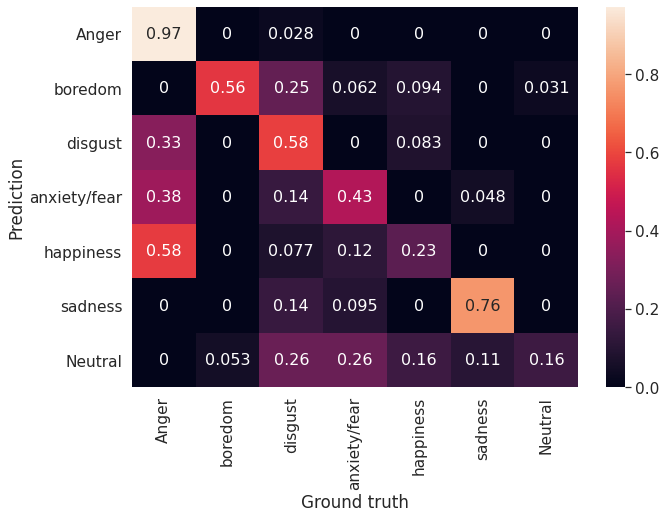

In [77]:
predictions = torch.cat(predictions_stack).cpu().numpy()
cm = confusion_matrix(val_data[:][1].cpu().numpy(), predictions, normalize='true')
names = list(emotion_id.keys())

names = [emotion_code[name] for name in names]

df_cm = pd.DataFrame(cm, index=names, columns=names)

plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.show()


On the confusion Matrix, it is clear that some labels such as Anger, neutral, anxiety and sadness are easier to classify than the rest. In our case, the algorithm struggle mainly on the cases of disgust and happiness. 

Not being a german speaker myself makes the interpretation of such a result complicated. After all, who am I to say if someone expressing his happiness in german looks like an angry individual.


Further data augmentation and an enhanced processing could be applied to increase our results, such as adding more weights to the happiness tag during training with a modified crossentropy loss.

Nonetheless, given the timeframe available, we will consider those results as satisfactory and will keep those facts in the back of our heads.

From our final analysis, we can see that despite being noisy, our validation loss is also exhibiting a convergence behavior. 
Overall, the system is learning to predict the emotion out of the speech patterns. 

Further improvements could be made to improve the performances such as replacing the LSTM and attention layers with a multi-headed attention mechanism with masks for the padding parts.
Nonetheless, given the timeframe, we will consider those results satisfying for this projects.

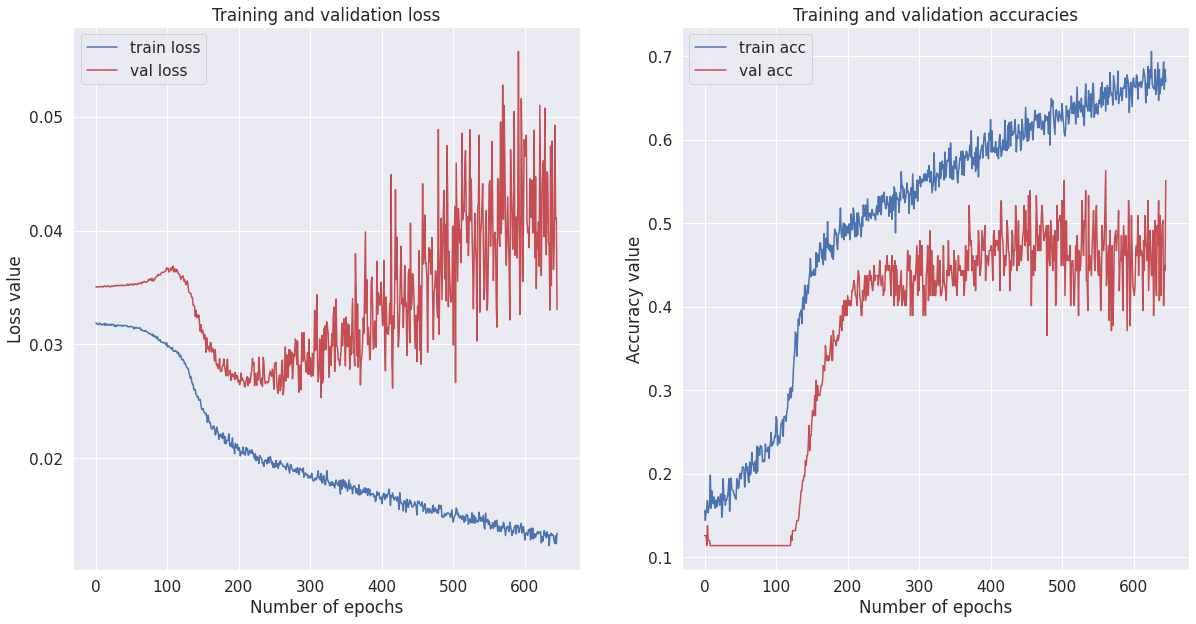

In [78]:
fig, axes = plt.subplots(ncols=2, figsize=(20,10))

axes[0].plot(train_losses,'b')
axes[0].plot(val_losses,'r')
axes[0].set_xlabel("Number of epochs")
axes[0].set_ylabel("Loss value")
axes[0].set_title("Training and validation loss")

axes[0].legend(['train loss','val loss'])


axes[1].plot(train_accs,'b')
axes[1].plot(val_accs,'r')
axes[1].set_xlabel("Number of epochs")
axes[1].set_ylabel("Accuracy value")
axes[1].set_title("Training and validation accuracies")

axes[1].legend(['train acc','val acc'])



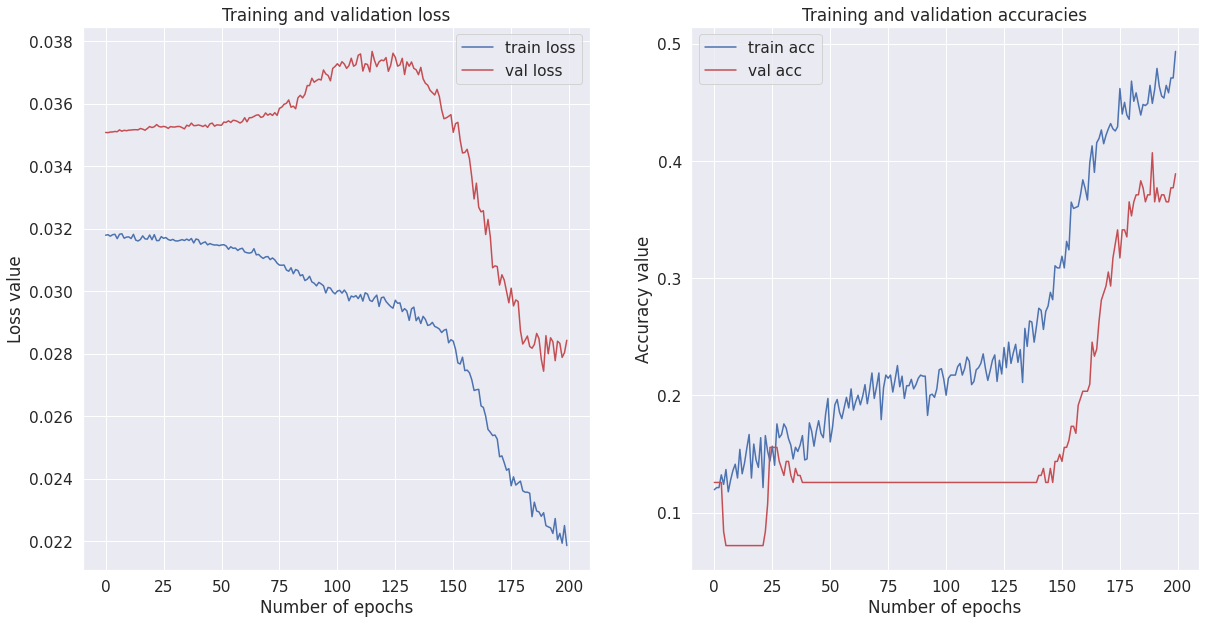

In [72]:
fig, axes = plt.subplots(ncols=2, figsize=(20,10))

axes[0].plot(train_losses,'b')
axes[0].plot(val_losses,'r')
axes[0].set_xlabel("Number of epochs")
axes[0].set_ylabel("Loss value")
axes[0].set_title("Training and validation loss")

axes[0].legend(['train loss','val loss'])


axes[1].plot(train_accs,'b')
axes[1].plot(val_accs,'r')
axes[1].set_xlabel("Number of epochs")
axes[1].set_ylabel("Accuracy value")
axes[1].set_title("Training and validation accuracies")

axes[1].legend(['train acc','val acc'])



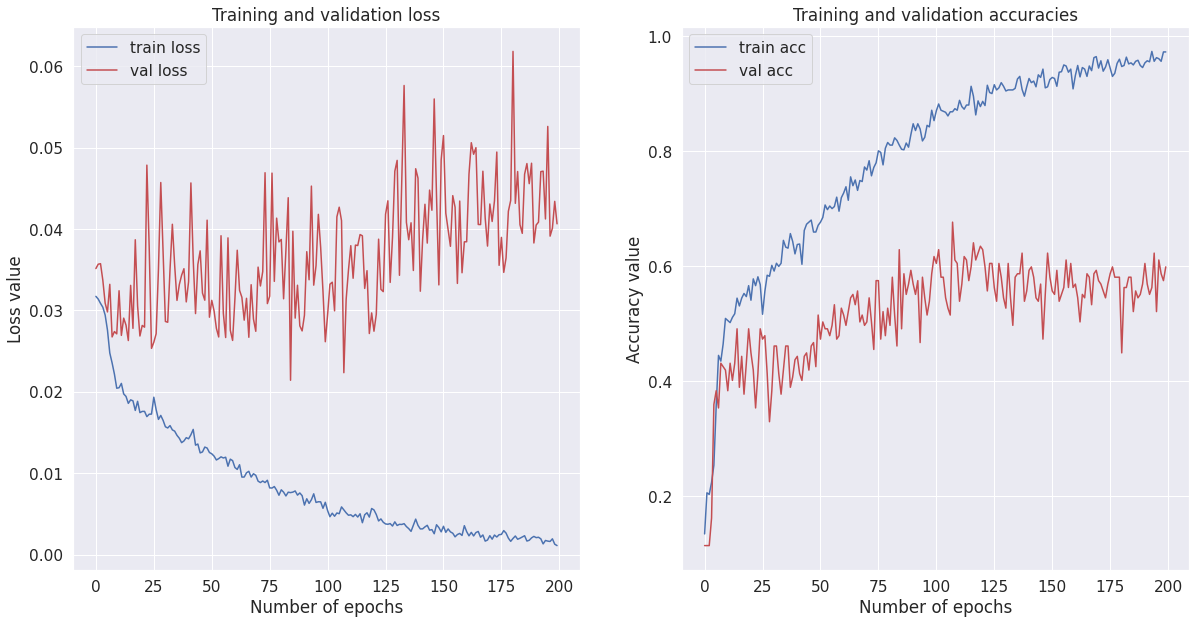

In [52]:
fig, axes = plt.subplots(ncols=2, figsize=(20,10))

axes[0].plot(train_losses,'b')
axes[0].plot(val_losses,'r')
axes[0].set_xlabel("Number of epochs")
axes[0].set_ylabel("Loss value")
axes[0].set_title("Training and validation loss")

axes[0].legend(['train loss','val loss'])


axes[1].plot(train_accs,'b')
axes[1].plot(val_accs,'r')
axes[1].set_xlabel("Number of epochs")
axes[1].set_ylabel("Accuracy value")
axes[1].set_title("Training and validation accuracies")

axes[1].legend(['train acc','val acc'])

